# LightGBM Regression sample
### Double crossvalidation emsemble model
### Hyper params are searhed by random search

### Import libraries

In [319]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 22.1 MB/s eta 0:00:00


In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
from tqdm import tqdm

import lightgbm as lgb
import shap

### Datset

In [2]:
# ----------------------------------------------
# Create sample dataset
# ----------------------------------------------

# Dataset
housing = fetch_california_housing()
housing_data = pd.DataFrame(data = housing.data, columns = housing.feature_names)
housing_data['target'] = housing.target
housing_data.reset_index(inplace = True, drop = True)

# Functions
def make_correlation_category(
        x_grid: list,
        y_grid: list,
        x_feature_name: str,
        y_feature_name: str,
        datset: pd.core.frame.DataFrame,
        catefory_names = list('ABCDEFGHIJKLMNOPQLSTUVWXYZ')
):
    i = 0
    index_list = []
    category_list = []
    for y1, y2 in zip(y_grid[:-1], y_grid[1:]):
        for x1, x2 in zip(x_grid[:-1], x_grid[1:]):
            temp_data = datset[(x1<=datset[x_feature_name]) & (datset[x_feature_name]<x2) & (y1<=datset[y_feature_name]) & (datset[y_feature_name]<y2)].copy()
            if temp_data.shape[0] > 0:
                index_list += temp_data.index.tolist()
                category_list += [catefory_names[i] for k in range(temp_data.shape[0])]
                i += 1
    return np.array(category_list)[np.argsort(np.array(index_list))]

# Make categorical features 1
housing_data['Area_category'] = make_correlation_category(
    x_grid = [32, 34, 36, 38, 40, 44],
    y_grid = [-126, -122, -120, -118, -116, -114],
    x_feature_name = 'Latitude',
    y_feature_name = 'Longitude',
    datset = housing_data,
)

# Make categorical features 2
housing_data['Room_num_category'] = make_correlation_category(
    x_grid = [0, 5, 10, 40],
    y_grid = [0, 20, 40, 170],
    x_feature_name = 'AveBedrms',
    y_feature_name = 'AveRooms',
    datset = housing_data,
)

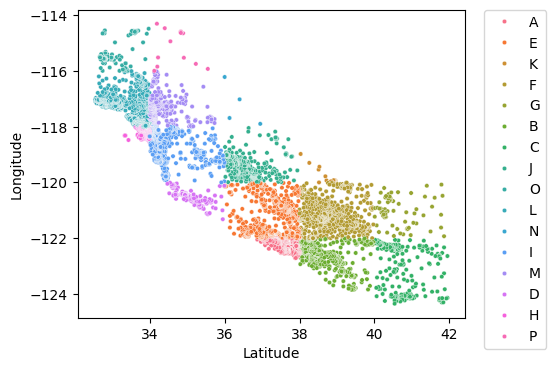

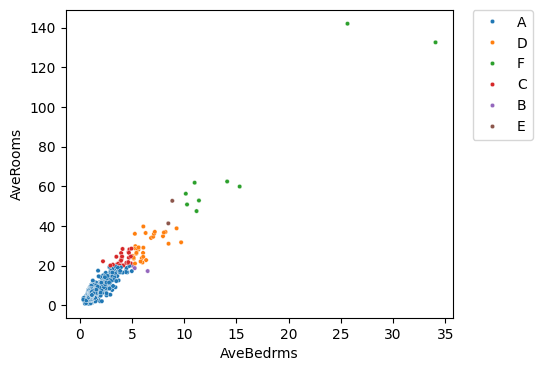

In [3]:
# ----------------------------------------------
# Category plot
# ----------------------------------------------

# Area_category
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
sns.scatterplot(x = 'Latitude', y = 'Longitude', data = housing_data, hue = 'Area_category', ax = ax, s = 10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

# Room_num_category
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
sns.scatterplot(x = 'AveBedrms', y = 'AveRooms', data = housing_data, hue = 'Room_num_category', ax = ax, s = 10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

In [4]:
# ----------------------------------------------
# Categorical encoding
# ----------------------------------------------

categorical_featues = ['Area_category', 'Room_num_category']
categorical_encoders = {}
for col in categorical_featues:
    enc = LabelEncoder()
    enc.fit(housing_data[col].unique())
    housing_data[col+'_encoded'] = enc.transform(housing_data[col])
    categorical_encoders[col] = enc

### Training LGBM Regression

In [210]:
# ----------------------------------------------
# Tuning parameters
# ----------------------------------------------

fixed_parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'boosting_type': 'gbdt',
    'verbose': -1
}

tuning_parameters = {
    'lambda_l1':         {'Sampling': 'log_uniform', 'Value': [1e-8, 10.0]},
    'lambda_l2':         {'Sampling': 'log_uniform', 'Value': [1e-8, 10.0]},
    'num_leaves':        {'Sampling': 'int_uniform', 'Value': [2, 256]},
    'feature_fraction':  {'Sampling': 'flo_uniform', 'Value': [ 0.4, 1.0]},
    'bagging_fraction':  {'Sampling': 'flo_uniform', 'Value': [ 0.4, 1.0]},
    'bagging_freq':      {'Sampling': 'int_uniform', 'Value': [1, 7]},
    'min_child_samples': {'Sampling': 'int_uniform', 'Value': [5, 100]},
}

 Outer fold: 0
------------ Inner fold 0 ------------


100%|██████████| 500/500 [05:14<00:00,  1.59it/s]


------------ Inner fold 1 ------------


100%|██████████| 500/500 [05:13<00:00,  1.59it/s]


------------ Inner fold 2 ------------


100%|██████████| 500/500 [05:21<00:00,  1.55it/s]


------------ Inner fold 3 ------------


100%|██████████| 500/500 [05:12<00:00,  1.60it/s]


------------ Inner fold 4 ------------


100%|██████████| 500/500 [05:16<00:00,  1.58it/s]


 Outer fold: 1
------------ Inner fold 0 ------------


100%|██████████| 500/500 [05:12<00:00,  1.60it/s]


------------ Inner fold 1 ------------


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


------------ Inner fold 2 ------------


100%|██████████| 500/500 [05:11<00:00,  1.61it/s]


------------ Inner fold 3 ------------


100%|██████████| 500/500 [05:20<00:00,  1.56it/s]


------------ Inner fold 4 ------------


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


 Outer fold: 2
------------ Inner fold 0 ------------


100%|██████████| 500/500 [05:15<00:00,  1.59it/s]


------------ Inner fold 1 ------------


100%|██████████| 500/500 [05:14<00:00,  1.59it/s]


------------ Inner fold 2 ------------


100%|██████████| 500/500 [05:17<00:00,  1.58it/s]


------------ Inner fold 3 ------------


100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


------------ Inner fold 4 ------------


100%|██████████| 500/500 [05:15<00:00,  1.58it/s]


 Outer fold: 3
------------ Inner fold 0 ------------


100%|██████████| 500/500 [05:12<00:00,  1.60it/s]


------------ Inner fold 1 ------------


100%|██████████| 500/500 [05:21<00:00,  1.55it/s]


------------ Inner fold 2 ------------


100%|██████████| 500/500 [05:16<00:00,  1.58it/s]


------------ Inner fold 3 ------------


100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


------------ Inner fold 4 ------------


100%|██████████| 500/500 [05:23<00:00,  1.54it/s]


 Outer fold: 4
------------ Inner fold 0 ------------


100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


------------ Inner fold 1 ------------


100%|██████████| 500/500 [05:17<00:00,  1.58it/s]


------------ Inner fold 2 ------------


100%|██████████| 500/500 [05:17<00:00,  1.57it/s]


------------ Inner fold 3 ------------


100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


------------ Inner fold 4 ------------


100%|██████████| 500/500 [05:28<00:00,  1.52it/s]


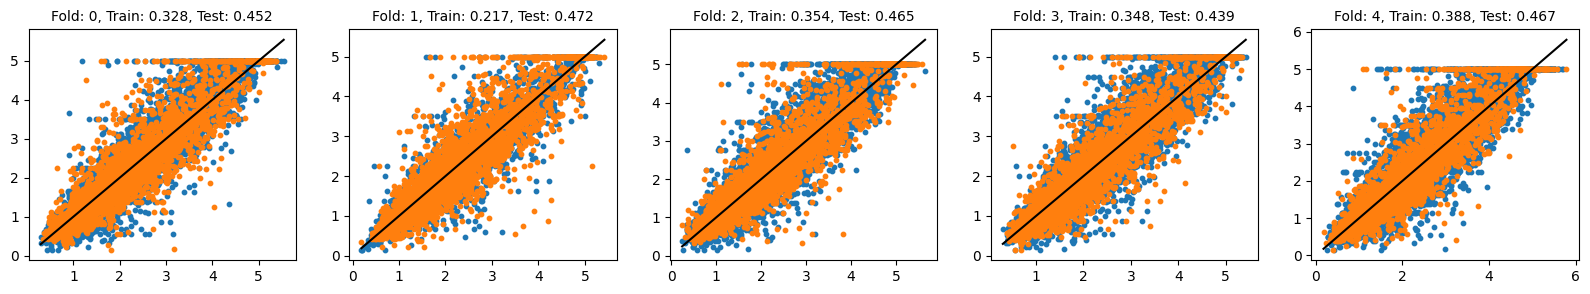

CPU times: user 3h 42min 17s, sys: 3min 28s, total: 3h 45min 45s
Wall time: 2h 12min 19s


In [212]:
%%time
# ----------------------------------------------
# Training (Duble cross validation)
# ----------------------------------------------

# Settings
num_tiral = 500
early_stopping_rounds = 50

# Feature names
num_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
cat_features = ['Area_category_encoded', 'Room_num_category_encoded']
target = ['target']

# Feature, target dataset
X = housing_data[num_features+cat_features].copy()
y = housing_data[target].copy()

# Outer cross validation
models = {}
parameter_tuning_data = pd.DataFrame()
outer_kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
fig, ax = plt.subplots(1, 5, figsize = (20, 3))
for outer_fold, (train_valid_index, test_index) in enumerate(outer_kfold.split(X)):
    print('====================================================================================')
    print(f' Outer fold: {outer_fold}')
    print('====================================================================================')

    # Test split
    X_train_valid, X_test = X.iloc[train_valid_index], X.iloc[test_index]
    y_train_valid, y_test = y.iloc[train_valid_index], y.iloc[test_index]

    # Hyper parameter sampling (Random search)
    sampling_params = {}
    for param_name, param_setting in tuning_parameters.items():
        if param_setting['Sampling'] == 'log_uniform':
            sampling_params[param_name] = loguniform.rvs(param_setting['Value'][0], param_setting['Value'][1], size = num_tiral)
        elif param_setting['Sampling'] == 'int_uniform':
            rng = np.random.default_rng()
            sampling_params[param_name] = rng.integers(param_setting['Value'][0], param_setting['Value'][1], size = num_tiral)
        elif param_setting['Sampling'] == 'flo_uniform':
            rng = np.random.default_rng()
            sampling_params[param_name] = rng.uniform(param_setting['Value'][0], param_setting['Value'][1], size = num_tiral)
        else:
            raise ValueError('Sampling method error.')

    # Inner cross validation
    inner_cross_validation_result = pd.DataFrame()
    inner_kfold = KFold(n_splits = 5, shuffle = True, random_state = 123)
    for inner_fold, (train_index, valid_index) in enumerate(inner_kfold.split(X_train_valid)):
        print(f'------------ Inner fold {inner_fold} ------------')

        # Valid split
        X_train, X_valid = X_train_valid.iloc[train_index], X_train_valid.iloc[valid_index]
        y_train, y_valid = y_train_valid.iloc[train_index], y_train_valid.iloc[valid_index]

        # Training
        for trial in tqdm(range(num_tiral)):
            # Hyper parameters
            params = fixed_parameters | {i:j[trial] for i, j in sampling_params.items()}
            # LGBM datset
            lgb_data_train = lgb.Dataset(X_train, label = y_train)
            # Fitting
            model = lgb.train(params, lgb_data_train)
            # Scoreing
            y_pred = model.predict(X_valid)
            RMSE = mean_squared_error(y_true = y_valid.values.ravel(), y_pred = y_pred, squared = False)
            # Log
            log = pd.DataFrame([[outer_fold, inner_fold, trial]], columns = ['outer_fold', 'inner_fold', 'trial'])
            for n, p in params.items():
                log[n] = p
            log['RMSE'] = RMSE
            inner_cross_validation_result = pd.concat([inner_cross_validation_result, log])

    # Best parameter
    best_trial = inner_cross_validation_result[['trial', 'RMSE']].groupby('trial').mean().sort_values('RMSE').index[0]
    best_params = fixed_parameters | {i:j[best_trial] for i, j in sampling_params.items()}
    parameter_tuning_data = pd.concat([parameter_tuning_data, inner_cross_validation_result])

    # Trainig with best parameter and early stopping
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle = True, test_size = 0.2)
    lgb_data_train = lgb.Dataset(X_train, label = y_train)
    lgb_data_valid = lgb.Dataset(X_valid, label = y_valid)
    model = lgb.train(
        params,
        lgb_data_train,
        valid_sets = [lgb_data_valid],
        num_boost_round = 10000,
        callbacks = [lgb.early_stopping(stopping_rounds = early_stopping_rounds, verbose = False), lgb.log_evaluation(-1)]
    )

    # Model score (test)
    test_y_pred = model.predict(X_test)
    test_RMSE = mean_squared_error(y_true = y_test.values.ravel(), y_pred = test_y_pred, squared = False)

    # Model score (train)
    train_y_pred = model.predict(X_train_valid)
    train_RMSE = mean_squared_error(y_true = y_train_valid.values.ravel(), y_pred = train_y_pred, squared = False)

    # Model save
    models[outer_fold] = {'Model': model, 'RMSE': test_RMSE}

    # Plot
    ax[outer_fold].scatter(train_y_pred, y_train_valid.values.ravel(), s = 10, label = 'Train')
    ax[outer_fold].scatter(test_y_pred, y_test.values.ravel(), s = 10, label = 'Test')
    ax[outer_fold].plot([min(min(train_y_pred), min(test_y_pred)), max(max(train_y_pred), max(test_y_pred))],
                        [min(min(train_y_pred), min(test_y_pred)), max(max(train_y_pred), max(test_y_pred))], color = 'k')
    ax[outer_fold].set_title(f'Fold: {outer_fold}, Train: {train_RMSE:.3f}, Test: {test_RMSE:.3f}', fontsize = 10)
plt.show()

### Inference

In [380]:
# ----------------------------------------------
# Trained model class
# ----------------------------------------------

class TrainedLGBMRegressor():
    def __init__(self, models, categorical_encoders, num_feature_names, cat_feature_names):
        self.models = models
        self.categorical_encoders = categorical_encoders
        self.num_feature_names = num_feature_names
        self.cat_feature_names = cat_feature_names
        self.weight = [1/j['RMSE'] for i, j in models.items()]/np.sum([1/j['RMSE'] for i, j in models.items()])

    def predict(self, dataset):
        # Categorical encode
        for col, enc in self.categorical_encoders.items():
            dataset[col+"_encoded"] = enc.transform(dataset[col])

        # Prediction
        pred_values = np.zeros(dataset.shape[0])
        for model_info, weight in zip(self.models.values(), self.weight):
            pred_values += model_info['Model'].predict(dataset[self.num_feature_names+self.cat_feature_names])*weight
        return pred_values

    def shap_calculation(self, dataset, n_sample = 1000):
        shape_values = np.zeros((n_sample, len(self.num_feature_names)+len(self.cat_feature_names)))
        dataset = dataset[self.num_feature_names+self.cat_feature_names].values
        rng = np.random.default_rng()
        sampling_index = rng.integers(0, dataset.shape[0], size = 1000)
        for model_info, weight in zip(self.models.values(), self.weight):
            explainer = shap.TreeExplainer(model_info['Model'], data = dataset)
            shape_values += explainer.shap_values(dataset[sampling_index])*weight
        self.shape_values = shape_values
        self.sampling_features = dataset[sampling_index]

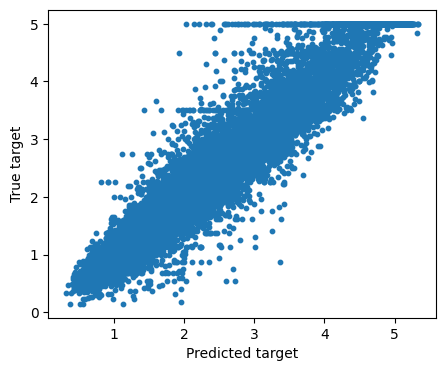

In [381]:
# ----------------------------------------------
# Inference
# ----------------------------------------------

# New Dataset (like)
new_dataset = housing_data.drop(columns = ['Area_category_encoded', 'Room_num_category_encoded']).copy()

# Trained model instance
trained_model = TrainedLGBMRegressor(
    models,
    categorical_encoders,
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['Area_category_encoded', 'Room_num_category_encoded']
)

# Prediction
new_dataset['Predicted_value'] = trained_model.predict(new_dataset)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.scatter(new_dataset['Predicted_value'], new_dataset['target'], s = 10)
ax.set_xlabel('Predicted target')
ax.set_ylabel("True target")
plt.show()

### Shap explanation

In [382]:
# ----------------------------------------------
# Shap value calculation
# ----------------------------------------------

trained_model.shap_calculation(housing_data)

 98%|===================| 983/1000 [00:22<00:00]       

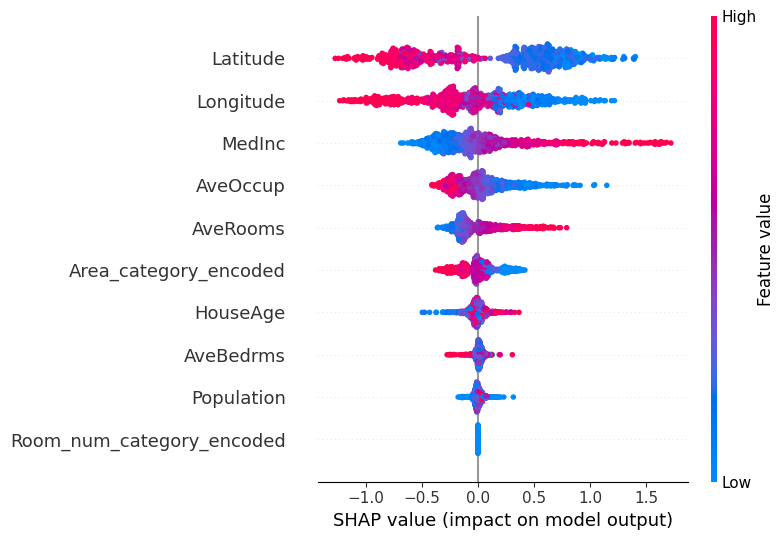

In [387]:
# ----------------------------------------------
# Plot 1
# ----------------------------------------------
shap.summary_plot(
    shap_values = trained_model.shape_values,
    features = trained_model.sampling_features,
    feature_names = num_features + cat_features
)

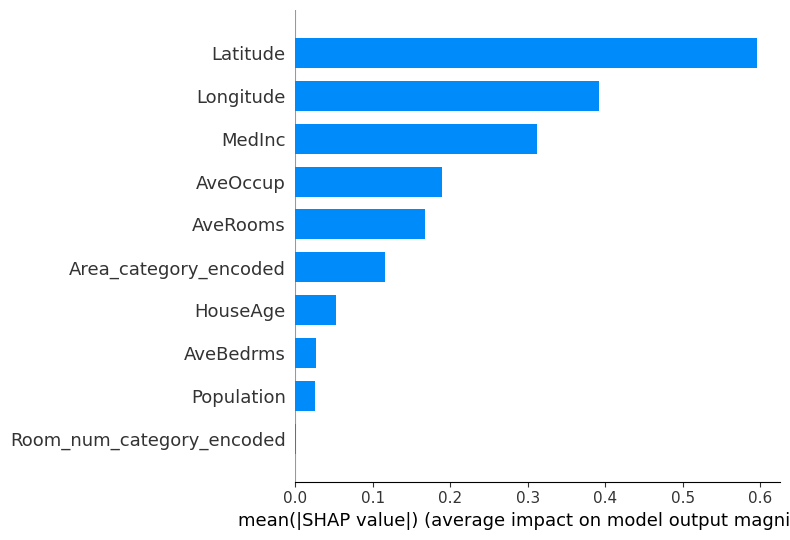

In [388]:
# ----------------------------------------------
# Plot 2
# ----------------------------------------------
shap.summary_plot(
    shap_values = trained_model.shape_values,
    features = trained_model.sampling_features,
    feature_names = num_features + cat_features,
    plot_type = 'bar'
)

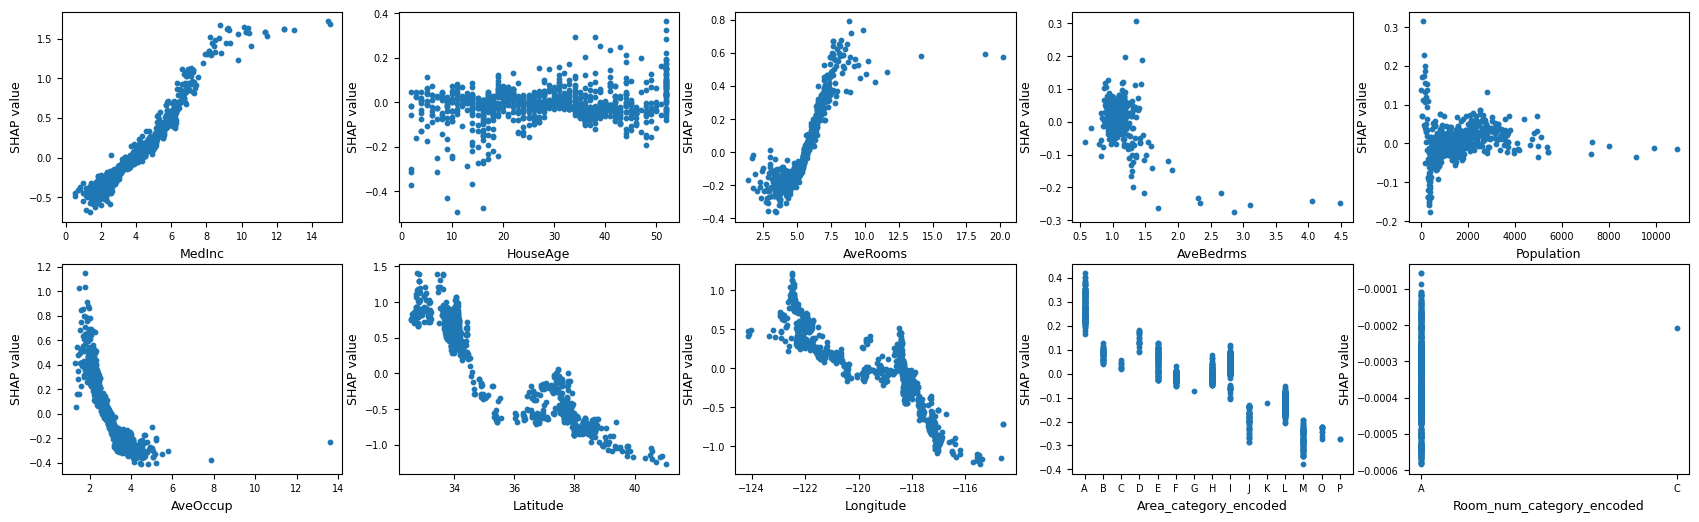

In [420]:
# ----------------------------------------------
# Plot 3
# ----------------------------------------------

fig, ax = plt.subplots(2, 5, figsize = (21, 6))
ax = ax.ravel()
for i, name in enumerate(num_features + cat_features):
    if i < len(num_features):
        ax[i].scatter(trained_model.sampling_features[:,i], trained_model.shape_values[:,i], s = 10)
    else:
        ax[i].scatter(np.sort(categorical_encoders[name.split('_encoded')[0]].inverse_transform(trained_model.sampling_features[:,i].astype(int))),
                      trained_model.shape_values[:,i][np.argsort(categorical_encoders[name.split('_encoded')[0]].inverse_transform(trained_model.sampling_features[:,i].astype(int)))],
                      s = 10)
    ax[i].set_xlabel(name, fontsize = 9)
    ax[i].set_ylabel('SHAP value', fontsize = 9)
    ax[i].tick_params(axis = 'both', which = 'major', labelsize = 7)
plt.show()

### Effect of hyper parameters

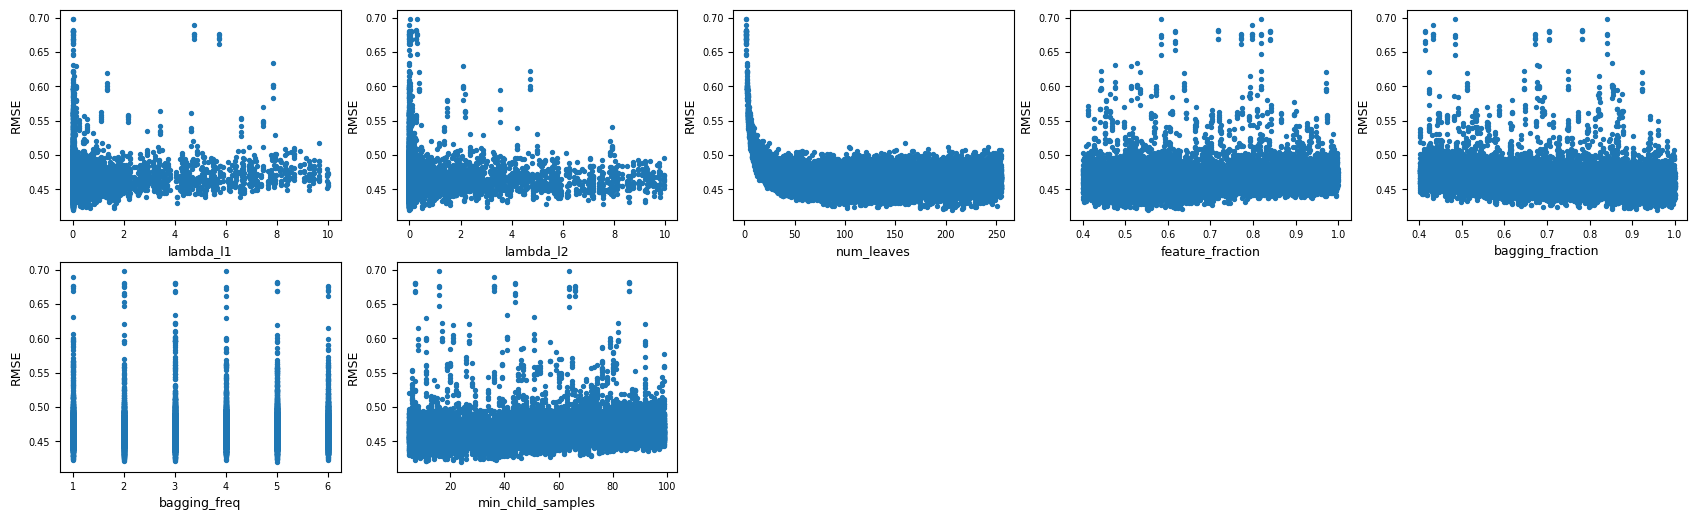

In [313]:
# ----------------------------------------------
# Paramter vs RMSE
# ----------------------------------------------

fig, ax = plt.subplots(2, 5, figsize = (21, 6))
ax = ax.ravel()
for i, k in enumerate(tuning_parameters.keys()):
    ax[i].scatter(parameter_tuning_data[k], parameter_tuning_data['RMSE'], s = 8)
    ax[i].set_xlabel(k, fontsize = 9)
    ax[i].set_ylabel('RMSE', fontsize = 9)
    ax[i].tick_params(axis = 'both', which = 'major', labelsize = 7)
[fig.delaxes(ax[k]) for k in range(i+1, 10)]
plt.show()